In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print("Tensorflow version: ",tf.__version__)
print("GPU detected : ",tf.config.list_physical_devices("GPU")) 


Tensorflow version:  2.2.0
GPU detected :  []


In [54]:
c=pd.read_csv("ner_dataset.csv", encoding="latin1")
c=c.fillna(method="ffill")
c

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [55]:
print(c["Word"].nunique())
c["Tag"].nunique()

35178


17

In [ ]:
words=list(set(c["Word"].values))
words.append("ENDPAD")
num_words=len(words)

In [ ]:
tags=list(set(c["Tag"].values))
num_tags=len(tags)

In [58]:
num_tags,num_words

(17, 35179)

# Retrieve sentences and tags

In [ ]:
class sentencegetter:
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s["Tag"].values.tolist()) ]

    self.grouped=self.data.groupby("Sentence #").apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [ ]:
getter = sentencegetter(c)
sentences=getter.sentences

In [61]:
len(sentences)

47959

# Define mappings between sentences and tags

In [ ]:
word2idx={w:i+1 for i,w in enumerate(words)} # i+1 beacuse of ENDPAD in list .
tag2idx={t:i for i,t in enumerate(tags)}

In [63]:
tag2idx

{'B-art': 1,
 'B-eve': 7,
 'B-geo': 5,
 'B-gpe': 13,
 'B-nat': 0,
 'B-org': 8,
 'B-per': 4,
 'B-tim': 14,
 'I-art': 10,
 'I-eve': 2,
 'I-geo': 9,
 'I-gpe': 3,
 'I-nat': 6,
 'I-org': 15,
 'I-per': 11,
 'I-tim': 12,
 'O': 16}

# Padding Input sequences

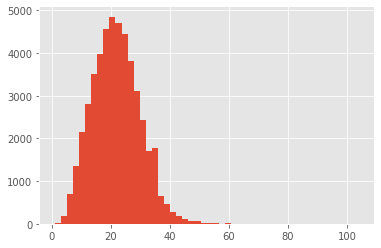

In [64]:
plt.hist([len(s) for s in sentences],bins=50)# the mean length of sentences is 20
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical# to convert tags into one hot vectors
max_len=50
X=[[word2idx[tupl[0]] for tupl in s] for s in sentences]
X=pad_sequences(maxlen=max_len,sequences=X,padding="post",value=num_words-1)
Y=[[tag2idx[tupl[2]] for tupl in s]for s in sentences]
Y=pad_sequences(maxlen=max_len,sequences=Y,padding="post",value=tag2idx["O"])### values????
Y=[to_categorical(i,num_classes=num_tags) for i in Y]                

In [86]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=1 )

TypeError: ignored

# build a bidirectional lstm model

In [ ]:
from tensorflow.keras import Model, Input # not sequential because more liberty for preparing the model
from tensorflow.keras.layers import LSTM, Embedding,Dense
from tensorflow.keras.layers import TimeDistributed,SpatialDropout1D,Bidirectional

In [68]:
input_word=Input(shape=(max_len,))
X=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
X=SpatialDropout1D(0.1)(X)
X=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(X)
outputs=TimeDistributed(Dense(units=num_tags,activation='softmax'))(X)
model=Model(inputs=input_word,outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy"])

# train the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback### itss not working for me

Epoch 1/3
1080/1080 [==============================] - 227s 210ms/step - loss: 0.1557 - accuracy: 0.9600 - val_loss: 0.0657 - val_accuracy: 0.9809
Epoch 2/3
1080/1080 [==============================] - 228s 211ms/step - loss: 0.0517 - accuracy: 0.9848 - val_loss: 0.0503 - val_accuracy: 0.9845
Epoch 3/3
1080/1080 [==============================] - 227s 210ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0469 - val_accuracy: 0.9855


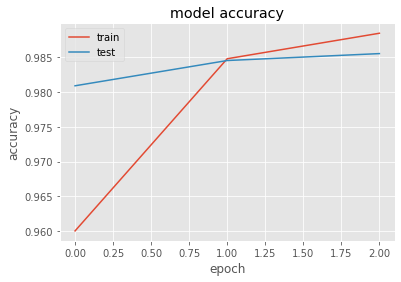

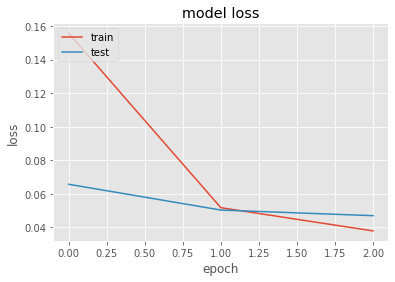

In [84]:
earlystopping=EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max')# if your accuracy dosent change after (patience value epochs) ,training  will stop.
callbacks=[earlystopping]

history=model.fit(x_train,np.array(y_train),validation_split=0.2,callbacks=callbacks,epochs=3,batch_size=32,verbose=1)# y_train was a list and should be converted to numpy array.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
model.evaluate(x_test,np.array(y_split))## by mistake y_test is y_split

150/150 [==============================] - 4s 25ms/step - loss: 0.0485 - accuracy: 0.9854


[0.04847012832760811, 0.9854253530502319]

In [129]:
i= np.random.randint(0,x_test.shape[0])
p=model.predict(np.array(x_test[i]))
p=np.argmax(p,axis=-1)
y_true=np.argmax(np.array(y_split),axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i],y_true,p):
  print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred[0]]))

Word           True 	 Pred

------------------------------
Muntazer       B-org	I-per
al-Zaidi       I-org	B-per
was            O	O
scheduled      O	O
to             O	O
go             O	O
on             O	O
trial          O	O
Wednesday      B-tim	I-tim
for            O	O
the            O	O
December       B-tim	I-tim
14             I-tim	I-tim
incident       O	O
in             O	O
Baghdad        B-geo	I-geo
.              O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O
endanger       O	O


In [112]:
p

16